# Demo of Robust PCA

The classical _Principal Component Analysis_ (PCA) is widely used for high-dimensional analysis and dimensionality reduction. Mathematically, if all the data points are stacked as column vectors of a (n, m)matrix $M$, PCA tries to decompose $M$ as

$$M = L + S,$$

where $L$ is a rank $k$ ($k<\min(n,m)$) matrix and $S$ is some perturbation/noise matrix. To obtain $L$, PCA solves the following optimization problem

$$\min_{L} ||M-L||_2,$$

given that rank($L$) <= $k$. However, the effectiveness of PCA relies on the assumption of the noise matrix $S$: $s_{i,j}$ is small and i.i.d. Gaussian. That means PCA is not robust to outliers in data $M$.

To resolve this issue, Candes, Emmanuel J. et al proposed _Robust Principal Component Analysis_ (Robust PCA or RPCA). The objective is still trying to decompose $M$ into $L$ and $S$, but instead optimizing the following problem

$$ \min_{L,S} ||L||_{*} + \lambda||S||_{1}$$

subject to $L+S = M$.

Minimizing the $l_1$-norm of $S$ is known to favour sparsity while minimizing the
nuclear norm of $L$ is known to favour low-rank matrices (sparsity of singular values). In this way, $M$ is decomposed to a low-rank matrix but not sparse $L$ and a sparse but not low rank $S$. Here $S$ can be viewed as a sparse noise matrix. Robust PCA allows the separation of sparse but outlying values from the original data.  

In addition, Zhou et al. further proposed a "stable" version of Robust PCA, which is called _Stable Principal Component Pursuit_ (Stable PCP or SPCP), which allows a non-sparse Gaussian noise term $Z$ in addition to $L$ and $S$:

$$M = L+S+Z.$$

Stable PCP is intuitively more practical since it combines the strength of classical PCA and Robust PCA. However, depending on the exact problem, the proper method should be selected.

There are many [applications of Robust PCA](https://www.comp.nus.edu.sg/~cs5240/lecture/robust-pca.pdf). Here, we show a few examples of its applications.

In [210]:
import numpy as np
import pandas as pd
from imageio import imread
import matplotlib.pylab as plt
from RobustPCA.rpca import RobustPCA  # install RobustPCA according to Readme.md
from RobustPCA.spcp import StablePCP

In [197]:
'''Helper functions
'''

def plot_LS(data,L,S, clim=None, cmap = 'nipy_spectral'):
    '''function for ploting decomposition results, toy example
    '''
    fig, ax = plt.subplots(1,4, figsize=(16,4))
    ax0 = ax[0].imshow(data, cmap=plt.get_cmap(cmap))
    ax[0].set_title("Demo data M", fontsize = 16)
    if clim:
        ax0.set_clim(clim[0], clim[1])   
    ax1 = ax[1].imshow(L, cmap=plt.get_cmap(cmap))
    ax[1].set_title("Low rank matrix L", fontsize = 16)
    if clim:
        ax1.set_clim(clim[0], clim[1])  
    ax2 = ax[2].imshow(S, cmap=plt.get_cmap(cmap))
    ax[2].set_title("Sparse noise S", fontsize = 16)
    if clim:
        ax2.set_clim(clim[0], clim[1]) 
    ax3 = ax[3].imshow(data-L-S, cmap=plt.get_cmap(cmap))
    ax[3].set_title("Residuals: M-L-S", fontsize = 16)
    if clim:
        ax3.set_clim(clim[0], clim[1])
        
def image_LS(image, L_image, S_image, thres=0):
    '''function for ploting decomposition results, image example
    '''
    fig, ax = plt.subplots(1,4,figsize=(16,6))
    ax[0].imshow(image.astype('uint8'))
    ax[0].set_title("Original image", fontsize = 16)
    ax[1].imshow(L_image.astype('uint8'))
    ax[1].set_title("Low rank matrix L", fontsize = 16)
    ax[2].imshow(np.abs(S_image).astype('uint8'))
    ax[2].set_title("Sparse matrix S", fontsize = 16);
    tmp = image*0.0
    tmp[(np.abs(S_image)>thres)] = image[(np.abs(S_image)>thres)]*1
    ax[3].imshow(tmp.astype('uint8'))
    ax[3].set_title("Filter image pixels with S!=0", fontsize = 16);
        
def foreground_filter(videodata, S, frame, thres=10):
    '''Using S to extract foreground
    '''
    # get indices for S values larger than thres
    indices = np.abs(S_video[frame,:,:])>thres
    
    # extract foreground
    foreground = S[frame,:,:].copy()*0.0
    foreground[indices] = videodata[frame,:,:][indices]
    
    return foreground

def imshow_LS(videodata, L_video, S_video, frame, thres=10):
    '''function for ploting decomposition results, video example
    '''

    fig, ax = plt.subplots(2,2, figsize=(16,10))
    ax[0,0].imshow(videodata.astype('uint8')[frame,:,:].reshape(1,px,py,3).squeeze())
    ax[0,0].set_title("Original picture", fontsize = 16)
    ax[0,0].set_axis_off()

    ax[0,1].imshow(L_video.astype('uint8')[frame,:,:].reshape(1,px,py,3).squeeze())
    ax[0,1].set_title("Background (Low rank matrix)", fontsize = 16)
    ax[0,1].set_axis_off()

    ax[1,0].imshow(S_video.astype('uint8')[frame,:,:].reshape(1,px,py,3).squeeze())
    ax[1,0].set_title("Foreground (Sparse noise)", fontsize = 16)
    ax[1,0].set_axis_off()

    fore = foreground_filter(videodata, S_video, frame=frame, thres=thres)
    ax[1,1].imshow(fore.astype('uint8').reshape(360,640,3).squeeze())
    ax[1,1].set_title("Foreground (filtered)", fontsize = 16);
    ax[1,1].set_axis_off();

### Toy example
Here a made-up data is used to demostrating robust PCA. The generated synthetic matrix $M$, original low-rank matrix $L$, and sparse noise $S$ are shown below.

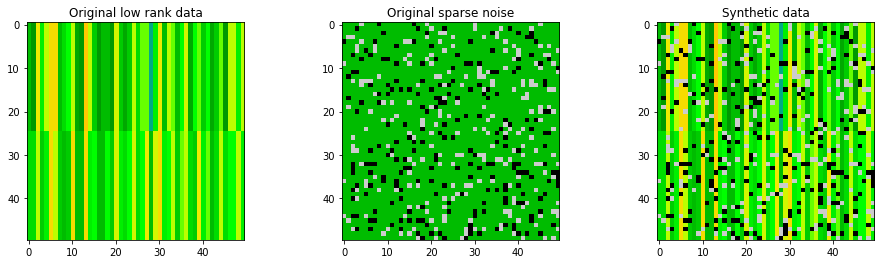

In [3]:
'''generate demo data
'''
np.random.seed(123)

# Low rank data
data_demo_lowrank = np.ones((50,50))*np.random.randint(10, size=(50))
data_demo_lowrank[0:25,:] = data_demo_lowrank[0:25,:]+ \
                            np.ones((25,50))*np.random.randint(low=-4,high=4, size=(50))

# Sparse (noise) data   
data_demo_sparse = - 100*np.random.binomial(1,0.1, size=2500).reshape([50,50])\
                   + 100*np.random.binomial(1,0.1, size=2500).reshape([50,50])
    
# Synthetic data M
data_demo = data_demo_lowrank + data_demo_sparse

# plot matrices
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax1 = ax[0].imshow(data_demo_lowrank, cmap=plt.get_cmap('nipy_spectral'))
ax2 = ax[1].imshow(data_demo_sparse, cmap=plt.get_cmap('nipy_spectral'))
ax3 = ax[2].imshow(data_demo, cmap=plt.get_cmap('nipy_spectral'))
ax1.set_clim([-20,20])
ax2.set_clim([-20,20])
ax3.set_clim([-20,20])
ax[0].set_title('Original low rank data');
ax[1].set_title('Original sparse noise');
ax[2].set_title('Synthetic data');

$M$ is decomposed via robust PCA and the result is shown below. Robust PCA did a great job to decompose the low rank matrix and sparse noise matrix.

In [4]:
# Robust PCA
rpca_demo = RobustPCA(tol = 0.000001)
rpca_demo.fit(data_demo)

# extract decomposed matrices
L_demo = rpca_demo.get_low_rank()
S_demo = rpca_demo.get_sparse()

Not converged!
Total error: 0.000002, allowed tolerance: 0.000001


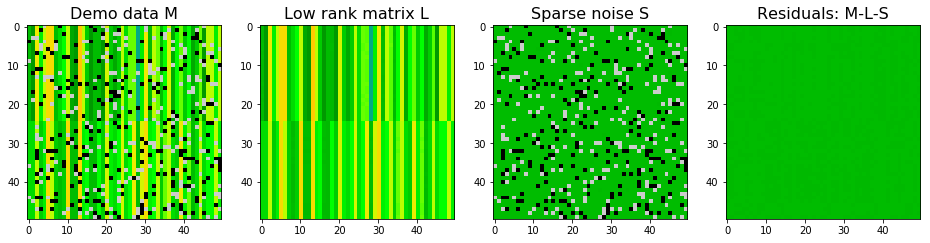

In [5]:
# plot decomposition for demo data
plot_LS(data_demo, L_demo, S_demo, clim=(-20,20))

$M$ is decomposed via stable PCP and the result is shown below. Stable PCP also did a great job to decompose the low rank matrix and sparse noise matrix.

In [6]:
# Stable PCP
spcp_demo = StablePCP(tol=0.000001, sigma=0.0001, max_iter=1000)
spcp_demo.fit(data_demo)

# extract decomposed matrices
L_demo = spcp_demo.get_low_rank()
S_demo = spcp_demo.get_sparse()

Converged!


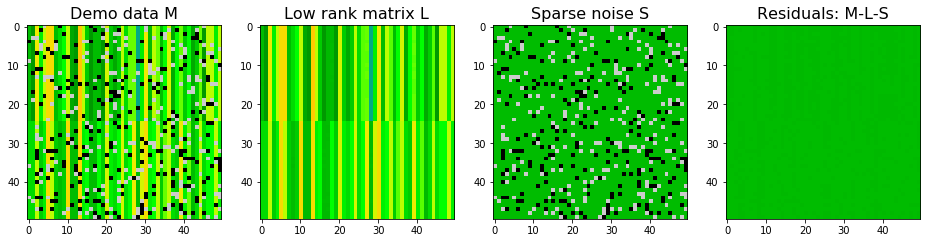

In [7]:
# plot decomposition for demo data
plot_LS(data_demo, L_demo, S_demo, clim=(-20,20))

We can also add some Gaussian noise (dense noise $E$) to the synthetic data and see how the two algorithms work. With Gaussian noise, stable PCP seems to give better approximations to true $L$ as shown in the SSE. For $S$, SSE is larger using stable PCP. However, stable PCP seems to be better in identifying sparse pixels. So stable PCP is more stable than robust PCA if there is a dense and non-ignorable noise background. Nevertheless, neither of them return a perfect decomposition. 

Notes:
* In robust PCA, the residual tolerance is a hyperparameter to tune when there is dense noise $E$.
* In stable PCP, the tolerance is not the residual tolerance, so it is better to set to be small. The hyperparameter is `sigma`, the estimated standard variation of the dense noise background.

In [8]:
# Adding Gaussian noise        
data_demo_G = data_demo + np.random.normal(size=(50,50))

Converged!
------------------------
Sum squared errors for low rank matrix: 1036.6182858509696
Sum squared errors for Sparse matrix: 1348.7311742049712
------------------------


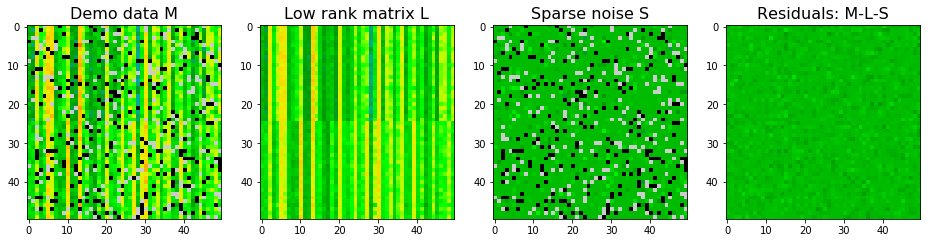

In [9]:
# Robust PCA
rpca_demo = RobustPCA(tol = 1000)
rpca_demo.fit(data_demo_G)
# extract decomposed matrices
L_demo = rpca_demo.get_low_rank()
S_demo = rpca_demo.get_sparse()
# plot decomposition for demo data
plot_LS(data_demo_G, L_demo, S_demo, clim=(-20,20))

print("------------------------")
print("Sum squared errors for low rank matrix:", np.sum((L_demo - data_demo_lowrank)**2))
print("Sum squared errors for Sparse matrix:", np.sum((S_demo - data_demo_sparse)**2))
print("------------------------")

Converged!
------------------------
Sum squared errors for low rank matrix: 1012.5172259255544
Sum squared errors for Sparse matrix: 2253.2615466077423
------------------------


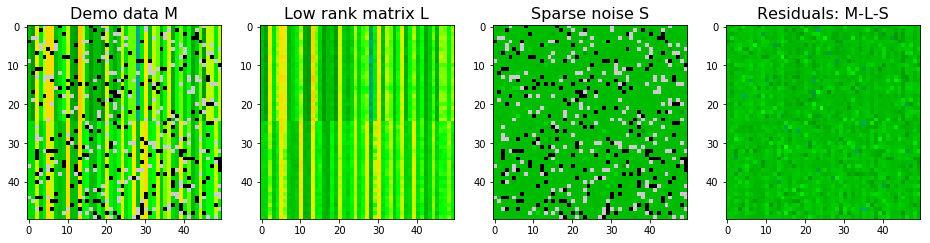

In [10]:
# Stable PCP
spcp_demo = StablePCP(tol=0.00001, sigma=1, max_iter=1000)
spcp_demo.fit(data_demo_G)

# extract decomposed matrices
L_demo = spcp_demo.get_low_rank()
S_demo = spcp_demo.get_sparse()
# plot decomposition for demo data
plot_LS(data_demo, L_demo, S_demo, clim=(-20,20))

print("------------------------")
print("Sum squared errors for low rank matrix:", np.sum((L_demo - data_demo_lowrank)**2))
print("Sum squared errors for Sparse matrix:", np.sum((S_demo - data_demo_sparse)**2))
print("------------------------")

We can also limit the maximum rank for the low rank matrix. It seems stable PCP is silghtly better after limiting the maximum rank to be 2. The rank of $L$ from stabe PCP decomposition without limitation is 12. 

Converged!
------------------------
Sum squared errors for low rank matrix: 895.5860009625777
Sum squared errors for Sparse matrix: 1939.0716317633464
------------------------


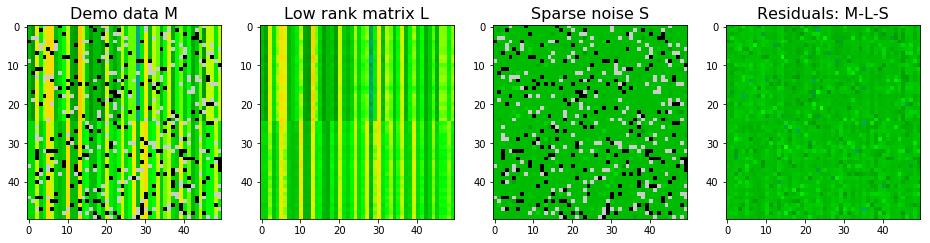

In [11]:
# Stable PCP
spcp_demo = StablePCP(tol=0.00001, sigma=1, max_iter=1000, max_rank=2)
spcp_demo.fit(data_demo_G)

# extract decomposed matrices
L_demo = spcp_demo.get_low_rank()
S_demo = spcp_demo.get_sparse()
# plot decomposition for demo data
plot_LS(data_demo, L_demo, S_demo, clim=(-20,20))

print("------------------------")
print("Sum squared errors for low rank matrix:", np.sum((L_demo - data_demo_lowrank)**2))
print("Sum squared errors for Sparse matrix:", np.sum((S_demo - data_demo_sparse)**2))
print("------------------------")

### Example on an image

Robust PCA can be used to remove noise. It is interesting to see what it does to an image. We can see that the low-rank $L$ is much more smoother than the original image. Most spotty white dots are removed in the low-rank $L$.

In [12]:
# read data
image = imread('./data/image1.jpg')*1.0

In [195]:
# robust PCA
rpca = RobustPCA(tol = 1, max_iter=1000)

L_image = image*0
S_image = image*0

for i in range(3):
    rpca.fit(image[:,:,i])
    L_image[:,:,i] = rpca.get_low_rank()
    S_image[:,:,i] = rpca.get_sparse()

Converged!
Converged!
Converged!


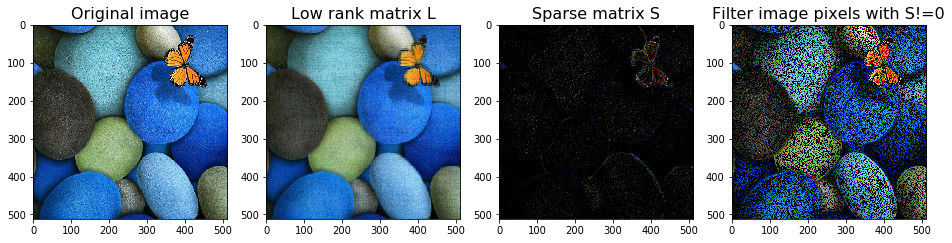

In [198]:
image_LS(image, L_image, S_image, thres=0)

In [202]:
# robust PCA with a max rank
rpca = RobustPCA(tol = 1, max_rank=10, max_iter=2000, use_fbpca=True)

L_image = image*0
S_image = image*0

for i in range(3):
    rpca.fit(image[:,:,i])
    L_image[:,:,i] = rpca.get_low_rank()
    S_image[:,:,i] = rpca.get_sparse()

Not converged!
Total error: 44434.035849, allowed tolerance: 1.000000
Not converged!
Total error: 60091.254484, allowed tolerance: 1.000000
Not converged!
Total error: 16089.792985, allowed tolerance: 1.000000


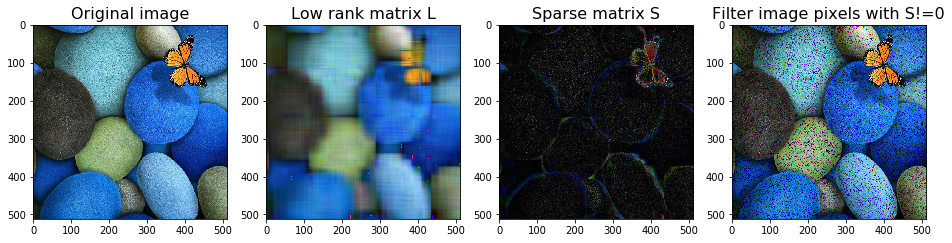

In [203]:
image_LS(image, L_image, S_image, thres=0)

### Separate the foreground and background in a sequence of images (video)
One of the most straightforward applications of Robust PCA is to separate the foreground and the background in a sequence of images with a fixed view. 

Here we use a clip of [_gangnam style_](https://www.youtube.com/watch?v=9bZkp7q19f0) as an example. The idea is to transform each frame into a vector and stack these frame vectors as a 2D array. This is a colour video, so there are three colour channels. Then we have a 2D array for each colour channel. 

In [84]:
import skvideo.io  

# load video data as images
videodata = skvideo.io.vread("./data/gangnamstyle.mp4")  
print("Shape of video data:", videodata.shape)

# reduce video size for faster decomposition
step = 3
px = int(1080/step)
py = int(1920/step)
videodata = videodata[:,::step,::step,:].reshape(90, int(px*py),3)*1.0
print("Shape of reduced-size video data:", videodata.shape)

Shape of video data: (90, 1080, 1920, 3)
Shape of reduced-size video data: (90, 230400, 3)


In [85]:
# robust PCA
rpca = RobustPCA(max_iter=500, use_fbpca=True, max_rank=1)

L_video = videodata*0
S_video = videodata*0

for i in range(3):
    rpca.fit(videodata[:,:,i])
    L_video[:,:,i] = rpca.get_low_rank()
    S_video[:,:,i] = rpca.get_sparse()

Not converged!
Total error: 4.206918, allowed tolerance: 0.000001
Not converged!
Total error: 3.537175, allowed tolerance: 0.000001
Not converged!
Total error: 5.325354, allowed tolerance: 0.000001


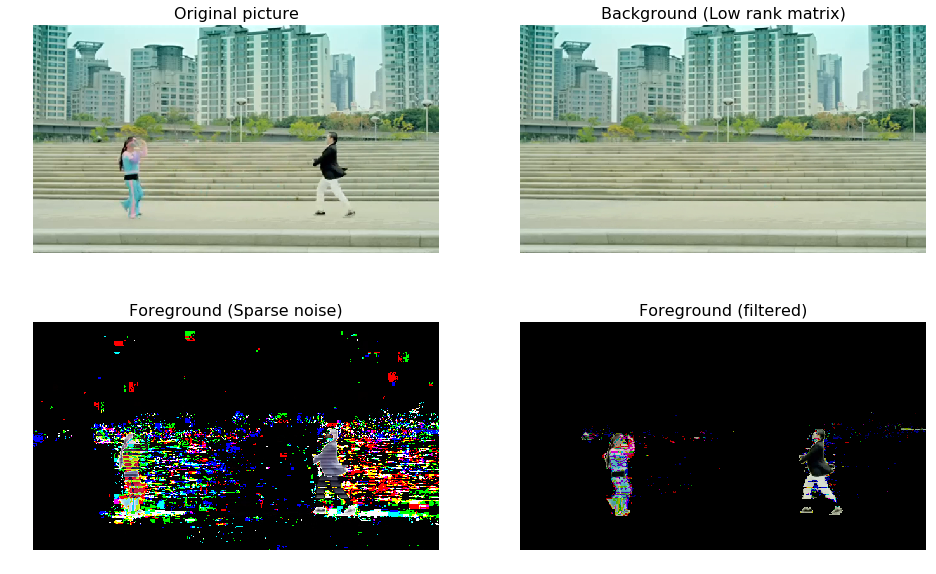

In [182]:
imshow_LS(videodata, L_video, S_video, frame=50)

### Seasonality data

Another application of Robust PCA is to remove outliers for seasonal data. Here we use "[Monthly sales of U.S. houses (thousands) 1965 – 1975](https://datamarket.com/data/set/22x5/monthly-sales-of-us-houses-thousands-1965-1975#!ds=22x5&display=line)" as an example. The sales have the period as 12 since it is monthly data. Then one can construct a 2D matrix by stacking sales data yearly, namely forming a $M$ with a shape ($n$, 12). $n$ is the number of years. Then one can decompose the matrix $M$ using robust PCA. The resulting $L$ is the seasonal time series with the outliers removed. 

In [238]:
data = pd.read_csv('data/monthly-sales-of-us-houses-thous.csv')
data.columns = ['Month', 'Sale']
data.head(3)

,Month,Sale
0,1965-01,38
1,1965-02,44
2,1965-03,53


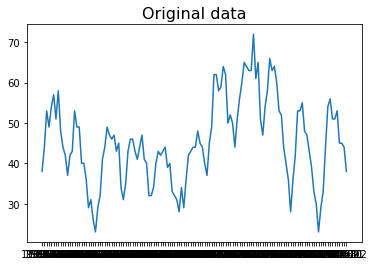

In [240]:
# Original data
plt.plot(data.Month, data.Sale);
plt.title("Original data", fontsize=16);

In [241]:
# construct 2D matrix for feeding rpca
M = data.Sale.values.reshape(11,12)

# Robust PCA
rpca = RobustPCA(max_iter=10000)

rpca.fit(M)
L = rpca.get_low_rank()
S = rpca.get_sparse()

Converged!


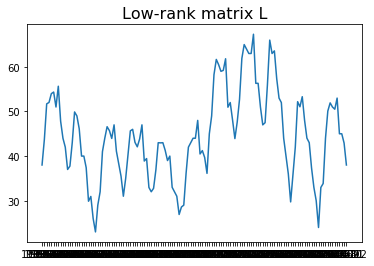

In [243]:
# Sales data with outliers removed
plt.plot(data.Month, L.reshape(132,1))
plt.title("Low-rank matrix L", fontsize=16);

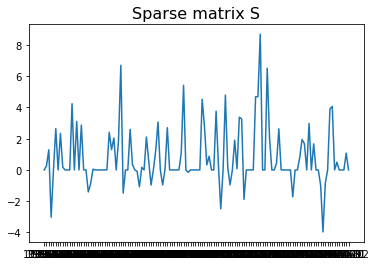

In [244]:
# removed outliers
plt.plot(data.Month, S.reshape(132,1))
plt.title("Sparse matrix S", fontsize=16);

### Discussion
From the example above, we can see the applications of robust PCA. However, the drawback of Robust PCA and Stable PCP is their scalability. They are generally slow since the implementation do SVD (singular value decomposition) in the converging iterations. Recently, a new algorithm was proposed: "[Grassmann Averages](https://ieeexplore.ieee.org/document/6909882)" for Scalable Robust PCA.

References:
* Candes, Emmanuel J. et al. "Robust Principal Component Analysis?" Journal of the ACM, Vol. 58, No. 3, Article 11, 2011.
* Zhou, Zihan, et al. "Stable principal component pursuit." Information Theory Proceedings (ISIT), 2010 IEEE International Symposium on. IEEE, 2010.